<a href="https://colab.research.google.com/github/ipeirotis/datasets/blob/master/notebooks/DOH_Restaurant_Inspections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www1.nyc.gov/site/doh/business/food-operators/the-inspection-process.page

See https://www1.nyc.gov/assets/doh/downloads/pdf/rii/blue-book.pdf 

## Download Latest Dataset

In [1]:
!curl 'https://data.cityofnewyork.us/api/views/43nn-pn8j/rows.csv?accessType=DOWNLOAD' -o restaurants.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 82.4M    0 82.4M    0     0  6243k      0 --:--:--  0:00:13 --:--:-- 7039k


In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv("restaurants.csv", dtype = 'object')

In [3]:
initial_size = len(df)
initial_size

198582

In [4]:
# Render our plots inline
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
df.dtypes

CAMIS                    object
DBA                      object
BORO                     object
BUILDING                 object
STREET                   object
ZIPCODE                  object
PHONE                    object
CUISINE DESCRIPTION      object
INSPECTION DATE          object
ACTION                   object
VIOLATION CODE           object
VIOLATION DESCRIPTION    object
CRITICAL FLAG            object
SCORE                    object
GRADE                    object
GRADE DATE               object
RECORD DATE              object
INSPECTION TYPE          object
Latitude                 object
Longitude                object
Community Board          object
Council District         object
Census Tract             object
BIN                      object
BBL                      object
NTA                      object
Location Point1          object
dtype: object

In [6]:
# Adding underscores in all column names
cols = df.columns
cols = cols.map(lambda x: x.replace(' ', '_').upper())
df.columns = cols

In [7]:
df.dtypes

CAMIS                    object
DBA                      object
BORO                     object
BUILDING                 object
STREET                   object
ZIPCODE                  object
PHONE                    object
CUISINE_DESCRIPTION      object
INSPECTION_DATE          object
ACTION                   object
VIOLATION_CODE           object
VIOLATION_DESCRIPTION    object
CRITICAL_FLAG            object
SCORE                    object
GRADE                    object
GRADE_DATE               object
RECORD_DATE              object
INSPECTION_TYPE          object
LATITUDE                 object
LONGITUDE                object
COMMUNITY_BOARD          object
COUNCIL_DISTRICT         object
CENSUS_TRACT             object
BIN                      object
BBL                      object
NTA                      object
LOCATION_POINT1          object
dtype: object

In [9]:
df.drop('LOCATION_POINT1', axis=1, inplace=True)   

## Cleaning Individual Columns

In [10]:
df.CAMIS.isnull().sum()

0

In [11]:
df.DBA.isnull().sum()

1764

In [12]:
# Checks that all CAMIS values correpond to a unique DBA value
# ie the same CAMIS always has the same DBA
max_cardinality = df[['DBA','CAMIS']].pivot_table(
    index='CAMIS',
    values='DBA',
    aggfunc=pd.Series.nunique
).DBA.max()

assert(max_cardinality==1)

### INSPECTION_TYPE

In [13]:
df.INSPECTION_TYPE.value_counts()

Cycle Inspection / Initial Inspection                          113056
Cycle Inspection / Re-inspection                                36685
Pre-permit (Operational) / Initial Inspection                   23331
Pre-permit (Operational) / Re-inspection                         7444
Administrative Miscellaneous / Initial Inspection                4311
Pre-permit (Non-operational) / Initial Inspection                2289
Cycle Inspection / Reopening Inspection                          1394
Pre-permit (Operational) / Compliance Inspection                 1334
Administrative Miscellaneous / Re-inspection                      863
Cycle Inspection / Compliance Inspection                          669
Pre-permit (Operational) / Reopening Inspection                   587
Smoke-Free Air Act / Initial Inspection                           528
Trans Fat / Initial Inspection                                    380
Inter-Agency Task Force / Initial Inspection                      374
Calorie Posting / In

In [14]:
sum(df.INSPECTION_TYPE.isnull())

4351

In [15]:
# We create a column "TO_DELETE" to mark the entries that we are not interested in.
# We will perform first the inspection/analysis on all the attributes, and then delete the rows

# Drop all cases where inspection is NULL
df['TO_DELETE'] = df.INSPECTION_TYPE.isnull()

In [16]:
sum(df['TO_DELETE'])

4351

In [17]:
# Break INSPECTION_TYPE into two columns, and also delete some inspection types

# Create a new column that contains the results of the split on the '/'' character
lst = df.INSPECTION_TYPE.str.split(' / ').values.tolist()
lst = [ l if type(l)==type(list()) else ['',''] for l in lst ]
t = pd.DataFrame(lst)


In [18]:
t[0].value_counts()

Cycle Inspection                151827
Pre-permit (Operational)         32890
Administrative Miscellaneous      5297
                                  4351
Pre-permit (Non-operational)      2478
Smoke-Free Air Act                 589
Trans Fat                          440
Inter-Agency Task Force            375
Calorie Posting                    335
Name: 0, dtype: int64

In [19]:
t[1].value_counts()

Initial Inspection              144554
Re-inspection                    45308
                                  4351
Compliance Inspection             2114
Reopening Inspection              2013
Second Compliance Inspection       232
Limited Inspection                  10
Name: 1, dtype: int64

In [20]:
# Keep only cycle inspections. Ignore admin, pre-permit, transfat, and calorie posting inspections
# We will only keep the initial inspections and the re-inspections. The other types are border cases

keep = df.INSPECTION_TYPE.isin( ['Cycle Inspection / Initial Inspection', 'Cycle Inspection / Re-inspection'])


In [21]:
# Check how many we will drop: ~keep means negation on the keep and summing up adds up the 'True'
sum(~keep)

48841

In [22]:
# Adding the "not keep" entries into the TO_DELETE

# The |= operator is a shortcut for df['TO_DELETE'] = df['TO_DELETE'] | ~keep
# We use the bit-OR operator (|), as we want to keep the existing deletions, and add the ones from the 
# additional condition
df['TO_DELETE'] |= ~keep

In [23]:
# Rename the two entries that we will keep into simpler values

df["INSPECTION_TYPE"].replace(
    to_replace='Cycle Inspection / Initial Inspection',
    value = 'Initial Inspection',
    inplace=True
)
df["INSPECTION_TYPE"].replace(
    to_replace='Cycle Inspection / Re-inspection',
    value = 'Re-inspection',
    inplace=True
)

In [24]:
sum(df['TO_DELETE'])

48841

### BORO

In [25]:
df.BORO.value_counts()

Manhattan        73335
Brooklyn         53102
Queens           47253
Bronx            18269
Staten Island     6559
0                   64
Name: BORO, dtype: int64

In [26]:
sum(df.BORO.isnull())

0

In [27]:
# Replace the "Missing" in BORO with null
# df.BORO = df.BORO.replace('Missing', np.NaN)

In [28]:
missing = set(df[df.BORO.isnull()].CAMIS)
# missing

In [29]:
sum(df.BORO == '0')

64

In [30]:
# Remove the entries with null/missing BORO value
# Not worth trying to fix.
df['TO_DELETE'] |= (df.BORO == '0')

In [31]:
sum(df['TO_DELETE'])

48863

### BUILDING

In [32]:
sum(df.BUILDING.isnull())

367

In [ ]:
# Inspect the entries with missing street number
# df[df.BUILDING.isnull()]

In [33]:
# Dropping the violations listed without street number
# Most are in train stations and in airports, but there
# are a few others in 'regular' locations

df['TO_DELETE'] |= df.BUILDING.isnull()

In [34]:
sum(df['TO_DELETE'])

49125

### STREET

In [35]:
# Check that no street values are empty
sum(df.STREET.isnull())

27

In [36]:
df['TO_DELETE'] |= df.STREET.isnull()

In [37]:
sum(df['TO_DELETE'])

49125

### ZIPCODE

In [38]:
sum(df.ZIPCODE.isnull())

2699

In [39]:
len(set(df[df.ZIPCODE.isnull()].CAMIS))

459

In [40]:
df['TO_DELETE'] |= df.ZIPCODE.isnull()

In [ ]:
# TODO: Fill in the missing zip codes, perhaps with geocoding of the addresses
# For now, we just drop the cases without ZIPCODE

### CUISINE DESCRIPTION

In [41]:
df.CUISINE_DESCRIPTION.value_counts()

American             33450
Chinese              19238
Coffee/Tea           12274
Pizza                12052
Latin American        7949
                     ...  
Fruits/Vegetables       22
New French              19
Czech                   12
Armenian                10
Basque                   9
Name: CUISINE_DESCRIPTION, Length: 87, dtype: int64

In [42]:
len(df.CUISINE_DESCRIPTION.value_counts())

87

In [43]:
sum(df.CUISINE_DESCRIPTION.isnull())

4351

In [ ]:
'''
df.CUISINE_DESCRIPTION.replace(
    to_replace='Café/Coffee/Tea',
    value = 'Cafe',
    inplace=True
)

df.CUISINE_DESCRIPTION.replace(
    to_replace='Latin (Cuban, Dominican, Puerto Rican, South & Central American)',
    value = 'Latin',
    inplace=True
)
'''

"\ndf.CUISINE_DESCRIPTION.replace(\n    to_replace='Café/Coffee/Tea',\n    value = 'Cafe',\n    inplace=True\n)\n\ndf.CUISINE_DESCRIPTION.replace(\n    to_replace='Latin (Cuban, Dominican, Puerto Rican, South & Central American)',\n    value = 'Latin',\n    inplace=True\n)\n"

### INSPECTION_DATE

In [44]:
df["INSPECTION_DATE"] = pd.to_datetime(df["INSPECTION_DATE"], format="%m/%d/%Y")

In [45]:
df.INSPECTION_DATE.describe(datetime_is_numeric=True)

count                           198582
mean     2019-05-23 00:53:10.041393152
min                1900-01-01 00:00:00
25%                2021-08-31 00:00:00
50%                2022-06-06 00:00:00
75%                2022-12-19 00:00:00
max                2023-06-03 00:00:00
Name: INSPECTION_DATE, dtype: object

In [46]:
sum(df.INSPECTION_DATE.isnull())

0

<Axes: >

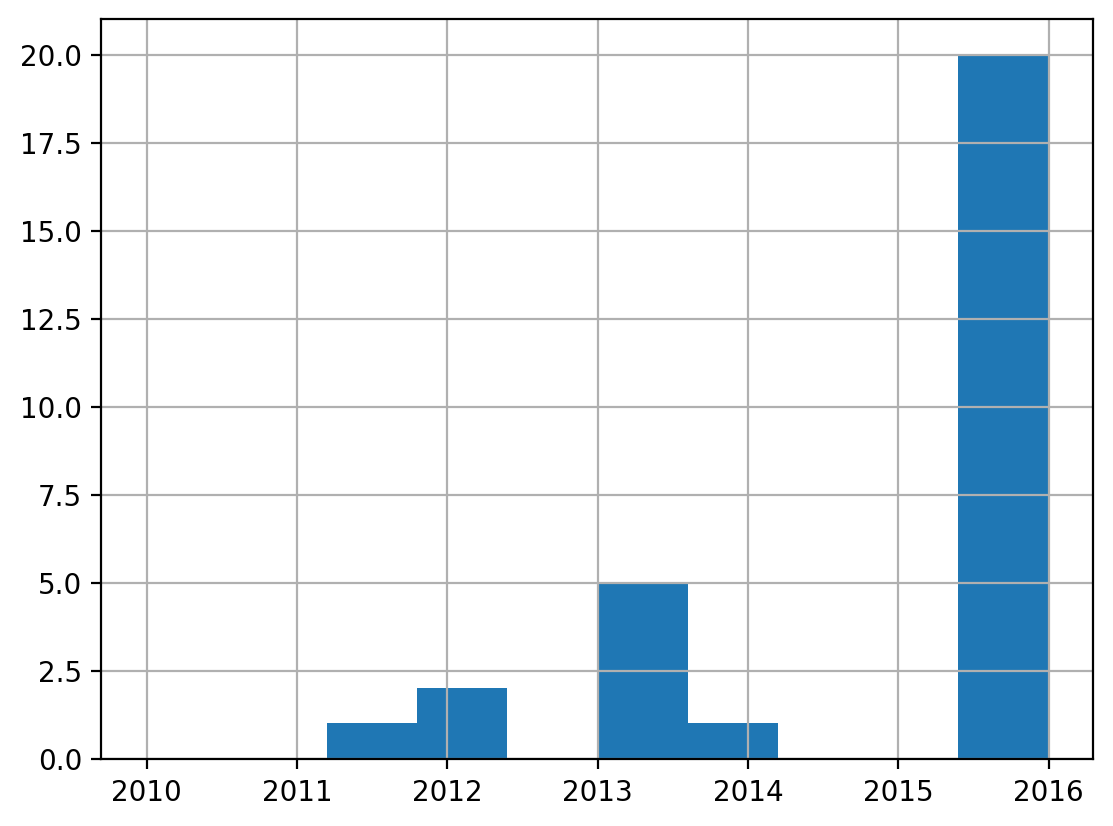

In [51]:
df.INSPECTION_DATE.hist(range=(pd.to_datetime('2010-01-01'),pd.to_datetime('2015-12-31')))

In [52]:
# Drop the 1900-01-01 inspections. These are all incorrect and we cannot fix them
df['TO_DELETE'] |= (df['INSPECTION_DATE'] == '1900-01-01')

In [53]:
# After analysis, it seems that we have minimal number of inspections before 2015
df['TO_DELETE'] |=  (df['INSPECTION_DATE'] < '2015-01-01')

In [54]:
sum(df['TO_DELETE'])

51340

### ACTION

In [55]:
sum(df.ACTION.isnull())

4351

In [56]:
df["ACTION"].value_counts()

Violations were cited in the following area(s).                                                                                       184089
Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.      7287
Establishment re-opened by DOHMH.                                                                                                       1762
No violations were recorded at the time of this inspection.                                                                             1089
Establishment re-closed by DOHMH.                                                                                                          4
Name: ACTION, dtype: int64

In [57]:
df["ACTION"].replace(
    to_replace='Violations were cited in the following area(s).',
    value = 'Violations found',
    inplace=True
)

In [58]:
df["ACTION"].replace(
    to_replace='No violations were recorded at the time of this inspection.',
    value = 'No violations',
    inplace=True
)

In [59]:
df["ACTION"].replace(
    to_replace='Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.',
    value = 'Establishment closed',
    inplace=True
)

In [60]:
df["ACTION"].replace(
    to_replace='Establishment re-opened by DOHMH.',
    value = 'Establishment re-opened',
    inplace=True
)

In [61]:
df["ACTION"].replace(
    to_replace='Establishment re-closed by DOHMH.',
    value = 'Establishment re-closed',
    inplace=True
)

In [62]:
df["ACTION"].value_counts()

Violations found           184089
Establishment closed         7287
Establishment re-opened      1762
No violations                1089
Establishment re-closed         4
Name: ACTION, dtype: int64

In [63]:
# Drop the Establishment re-opened and re-closed cases
# as the inspection scores for these can be misleading
df['TO_DELETE'] |=  (df.ACTION == 'Establishment re-closed')
df['TO_DELETE'] |=  (df.ACTION == 'Establishment re-opened')
df['TO_DELETE'] |=  df.ACTION.isnull()

In [64]:
sum(df['TO_DELETE'])

51340

### SCORE

In [65]:
df["SCORE"] = pd.to_numeric(df["SCORE"])

In [66]:
df.SCORE.describe()

count    187570.000000
mean         22.104233
std          17.031039
min           0.000000
25%          11.000000
50%          18.000000
75%          30.000000
max         157.000000
Name: SCORE, dtype: float64

In [67]:
len(df)

198582

In [68]:
len( df[ df.SCORE < 0 ] )

0

In [69]:
df['TO_DELETE'] |= (df.SCORE < 0)

In [70]:
sum(df['TO_DELETE'])

51340

In [71]:
# Drop cases reported as "no violations but with positive score"
df['TO_DELETE'] |= ((df.SCORE > 0)  & (df.ACTION == 'No violations'))

# Drop cases with zero score but with violations found
df['TO_DELETE'] |= ((df.SCORE == 0)  & (df.ACTION == 'Violations found'))

In [72]:
# Drop incorrectly scored inspections
df['TO_DELETE'] |=  (df.GRADE=='A') & (df.SCORE>13)

df['TO_DELETE'] |=  (df.GRADE=='B') & ( (df.SCORE<14) | (df.SCORE>27) )

# Drop incorrectly scored inspections
df['TO_DELETE'] |=  (df.GRADE=='C') & (df.SCORE<28)


In [73]:
sum(df['TO_DELETE'])

58522

### RECORD_DATE

In [74]:
df["RECORD_DATE"] = pd.to_datetime(df["RECORD_DATE"], format="%m/%d/%Y")

In [75]:
# Drop record date field, as it only contains a single value
df = df.drop( 'RECORD_DATE', axis = 'columns')

### GRADE

In [76]:
df.GRADE.value_counts()

A    68892
B    10045
N     7390
C     5297
Z     4701
P      568
Name: GRADE, dtype: int64

In [77]:
sum(df.GRADE.isnull())

101689

In [78]:
df.query(" GRADE == 'G' ")

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE_DESCRIPTION,INSPECTION_DATE,ACTION,...,INSPECTION_TYPE,LATITUDE,LONGITUDE,COMMUNITY_BOARD,COUNCIL_DISTRICT,CENSUS_TRACT,BIN,BBL,NTA,TO_DELETE


In [79]:
# Seems that all the "G" correspond to "A"
df.GRADE.replace('G', 'A', inplace=True)

In [80]:
# P assigned to 'Establishment re-opened' actions
df.query(" GRADE == 'P' ")

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE_DESCRIPTION,INSPECTION_DATE,ACTION,...,INSPECTION_TYPE,LATITUDE,LONGITUDE,COMMUNITY_BOARD,COUNCIL_DISTRICT,CENSUS_TRACT,BIN,BBL,NTA,TO_DELETE
483,50033660,RUSTY'S FLAVOR,Manhattan,2261,ADAM CLAYTON POWELL JR BOULEVARD,NaN,2123683403,Caribbean,2022-04-21,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,0,0,NaN,NaN,NaN,NaN,1,NaN,True
551,50127840,PAPA JOHNS PIZZA,Brooklyn,189,AVENUE U,11223,9173026461,Pizza,2022-09-29,Establishment re-opened,...,Pre-permit (Operational) / Reopening Inspection,40.596552893604,-73.977102194092,311,47,040000,3191212,3071000045,BK29,True
868,40931583,CONNECTICUT MUFFIN,Brooklyn,423,MYRTLE AVENUE,11205,7189350087,Coffee/Tea,2021-08-19,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.693136988863,-73.968666715239,302,35,019100,3054300,3018880001,BK69,True
2460,50118971,EL POLLO SABROSON,Queens,6635,GRAND AVE,11378,7184069717,Latin American,2022-07-11,Establishment re-opened,...,Pre-permit (Operational) / Reopening Inspection,40.724627620642,-73.897762228849,405,30,051700,4435555,4027240163,QN30,True
2669,50002106,PYRAMIDS HOOKAH AND BAR,Queens,40-19,BELL BOULEVARD,11361,7187466524,American,2018-12-13,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.76407402447,-73.771216062182,411,19,112300,4438269,4062880001,QN46,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195807,50085772,MX BREAD,Brooklyn,5414,7 AVENUE,11220,3478895228,Bakery Products/Desserts,2022-01-31,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.640062455944,-74.008395472406,307,43,010000,3014755,3008250045,BK34,True
195940,50108172,NARUTO RAMEN,Brooklyn,276,5 AVENUE,11215,3472497683,Asian/Asian Fusion,2021-09-17,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.674299729901,-73.982035966568,306,39,013300,3020594,3009640041,BK37,True
196707,50103408,ASTORIA COFFEE SHOP,Queens,3410,STEINWAY ST,11101,7183617770,Coffee/Tea,2021-10-05,Establishment re-opened,...,Pre-permit (Operational) / Reopening Inspection,40.756334385567,-73.921150007333,401,26,015700,4010902,4006720025,QN70,True
197454,41672897,YUMMY TACO,Queens,11404,SUTPHIN BLVD,11434,7188482227,Tex-Mex,2021-09-03,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.686077327043,-73.793753592136,412,28,019000,4259572,4119800003,QN76,True


In [81]:
# P assigned to 'Establishment re-opened' actions
df.query(" GRADE == 'P' ").ACTION.value_counts()

Establishment re-opened    568
Name: ACTION, dtype: int64

In [82]:
# P assigned to 'Reopening Inspection' inspection types
df.query(" GRADE == 'P' ").INSPECTION_TYPE.value_counts()

Cycle Inspection / Reopening Inspection            397
Pre-permit (Operational) / Reopening Inspection    171
Name: INSPECTION_TYPE, dtype: int64

In [ ]:
# df.query(" GRADE == 'Z' ").SCORE.hist(bins=100)

In [83]:
# TODO: Figure out what Z, and Not Yet Graded means in GRADE
# Until then, we just replace these values with NULL, keeping only the A, B, C grades

# 
df.GRADE.value_counts()

A    68892
B    10045
N     7390
C     5297
Z     4701
P      568
Name: GRADE, dtype: int64

In [84]:
df['TO_DELETE'] |=  (df.GRADE=='Z')
df['TO_DELETE'] |=  (df.GRADE=='P')
df['TO_DELETE'] |=  (df.GRADE=='N') # Not Yet Graded
df['TO_DELETE'] |=  (df.GRADE=='Not Yet Graded')

### GRADE_DATE

In [85]:
df["GRADE_DATE"] = pd.to_datetime(df["GRADE_DATE"], format="%m/%d/%Y")


In [86]:
# Grade date and inspection date should be the same. 
assert np.abs((df.GRADE_DATE - df.INSPECTION_DATE).dropna()).sum().days == 0

In [87]:
# Check that is there is a grade date, a grade is also assigned
assert sum ( ~df.GRADE_DATE.isnull() & df.GRADE.isnull() )  == 0

In [88]:
# We do not need GRADE DATE if we have INSPECTION DATE
df = df.drop("GRADE_DATE", axis='columns')

### VIOLATION_CODE and VIOLATION_DESCRIPTION

In [89]:
df.VIOLATION_CODE.isnull().sum()

5441

In [90]:
# All the cases where violation code is NULL should be either cases that we delete
# or a "No violations" case
check = df[df.VIOLATION_CODE.isnull() & ~df.TO_DELETE & (df.ACTION!='No violations')]

assert( len(check) == 0 )


In [91]:
df.VIOLATION_DESCRIPTION.isnull().sum()

5441

In [96]:
# Checks that all VIOLATION_CODE has unique VIOLATION_DESCRIPTION
df[['VIOLATION_CODE','VIOLATION_DESCRIPTION']].drop_duplicates().pivot_table(
    index='VIOLATION_CODE',
    values='VIOLATION_DESCRIPTION',
    aggfunc=pd.Series.nunique
).sort_values('VIOLATION_DESCRIPTION', ascending=False).head(20)

,VIOLATION_DESCRIPTION
VIOLATION_CODE,
06C,4
05C,4
06A,4
02A,3
10H,3
05D,3
05B,3
04N,3
08C,3


In [93]:
df['TO_DELETE'] |=  (df.VIOLATION_DESCRIPTION == 'Caloric content not posted on menus, menu boards or food tags, in a food service establishment that is 1 of 15 or more outlets operating the same type of business nationally under common ownership or control, or as a franchise or doing business under the same name, for each menu item that is served in portions, the size and content of which are standardized.')

In [ ]:
# In the dataset we have a NULL violation, when there is no violation
# To make this more explicit, we replace NULL with 000
# df.VIOLATION_CODE.fillna('000', inplace=True)

In [94]:
df.VIOLATION_CODE.isnull().sum()

5441

In [ ]:
## LATITUDE and LONGITUDE

In [95]:
df['LONGITUDE'] = pd.to_numeric(df['LONGITUDE'])
df['LATITUDE'] = pd.to_numeric(df['LATITUDE'])

### MISC analysis

In [97]:
# Find the unique values in each column
# 
# df.describe(include = [np.object, 'category']).T['unique']
unique = df.describe(include = 'all').T['unique'].sort_values()

for column in unique.index:
    if unique[column] < 200:
        print(df[column].value_counts())
        print("=====")

<ipython-input-97-c484cf3850a3>:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  unique = df.describe(include = 'all').T['unique'].sort_values()


False    133595
True      64987
Name: TO_DELETE, dtype: int64
=====
Critical          107287
Not Critical       84633
Not Applicable      6662
Name: CRITICAL_FLAG, dtype: int64
=====
Violations found           184089
Establishment closed         7287
Establishment re-opened      1762
No violations                1089
Establishment re-closed         4
Name: ACTION, dtype: int64
=====
Manhattan        73335
Brooklyn         53102
Queens           47253
Bronx            18269
Staten Island     6559
0                   64
Name: BORO, dtype: int64
=====
A    68892
B    10045
N     7390
C     5297
Z     4701
P      568
Name: GRADE, dtype: int64
=====
Initial Inspection                                             113056
Re-inspection                                                   36685
Pre-permit (Operational) / Initial Inspection                   23331
Pre-permit (Operational) / Re-inspection                         7444
Administrative Miscellaneous / Initial Inspection                43

In [98]:
df.dtypes

CAMIS                            object
DBA                              object
BORO                             object
BUILDING                         object
STREET                           object
ZIPCODE                          object
PHONE                            object
CUISINE_DESCRIPTION              object
INSPECTION_DATE          datetime64[ns]
ACTION                           object
VIOLATION_CODE                   object
VIOLATION_DESCRIPTION            object
CRITICAL_FLAG                    object
SCORE                           float64
GRADE                            object
INSPECTION_TYPE                  object
LATITUDE                        float64
LONGITUDE                       float64
COMMUNITY_BOARD                  object
COUNCIL_DISTRICT                 object
CENSUS_TRACT                     object
BIN                              object
BBL                              object
NTA                              object
TO_DELETE                          bool


## Deleting Entries

In this section, we use the results of the analysis above, and delete (additional) entries that will not be useful in our analysis. (Note that it is important to document this, as others may want to go back to the original source, if the entries that we leave are not sufficient.)

In [99]:
len(df)

198582

In [100]:
assert len(df) == initial_size

In [101]:
df = df[ df.TO_DELETE == False].copy()

In [102]:
len(df)

133595

In [103]:
df[df.VIOLATION_CODE.isnull()].VIOLATION_DESCRIPTION

158       NaN
338       NaN
436       NaN
443       NaN
513       NaN
         ... 
195260    NaN
196134    NaN
196552    NaN
196778    NaN
198565    NaN
Name: VIOLATION_DESCRIPTION, Length: 278, dtype: object

## Additional Data Quality Checks

In [104]:


assert sum(df.INSPECTION_TYPE.isnull()) == 0

assert len(set(df.INSPECTION_TYPE.values)) == 2

df["INSPECTION_TYPE"] =  pd.Categorical(df["INSPECTION_TYPE"], ordered=False)

In [105]:
# Check that no borough entries are empty
assert sum(df.BORO.isnull()) == 0

df["BORO"] =  pd.Categorical(df["BORO"], ordered=False)

In [106]:
# Check that no street numbers are empty
assert sum(df.BUILDING.isnull()) == 0

In [107]:
assert sum(df.STREET.isnull()) == 0

In [108]:

assert sum(df.CUISINE_DESCRIPTION.isnull()) == 0

df["CUISINE_DESCRIPTION"] =  pd.Categorical(df["CUISINE_DESCRIPTION"], ordered=False)

In [109]:
# We only keep three different actions
assert len(set(df.ACTION.values)) == 3

# No action is empty
assert sum(df.ACTION.isnull()) == 0

df["ACTION"] =  pd.Categorical(df["ACTION"], ordered=False)

In [110]:
# The below drops any grade values other than A, B, C, and converts the remaining entries to null
df["GRADE"] =  pd.Categorical(df["GRADE"], categories = ['A', 'B', 'C'], ordered=True)

# https://www1.nyc.gov/assets/doh/downloads/pdf/rii/how-we-score-grade.pdf
# 0-13 get an A
assert sum( (df.GRADE=='A') & (df.SCORE>13)) == 0

# 14-27 get a B
assert sum( (df.GRADE=='B') & ( (df.SCORE<14) | (df.SCORE>27) ) ) == 0

# 28- get a C
assert sum( (df.GRADE=='C') & (df.SCORE<28) ) == 0

# TODO: In principle, a NULL grade is only when the score is above 14, and it was an initial inspection

In [ ]:
# Check that is there is a grade date, a grade is also assigned
# assert sum ( ~df.GRADE_DATE.isnull() & df.GRADE.isnull() ) == 0

In [111]:
df["VIOLATION_CODE"] =  pd.Categorical(df["VIOLATION_CODE"], ordered=False)
df["CRITICAL_FLAG"] =  pd.Categorical(df["CRITICAL_FLAG"], ordered=False)


In [112]:
df [ df.VIOLATION_CODE.isnull() ].VIOLATION_DESCRIPTION

158       NaN
338       NaN
436       NaN
443       NaN
513       NaN
         ... 
195260    NaN
196134    NaN
196552    NaN
196778    NaN
198565    NaN
Name: VIOLATION_DESCRIPTION, Length: 278, dtype: object

## Normalization

### Violation Codes

In [113]:
# Recreating the table at https://www1.nyc.gov/assets/doh/downloads/pdf/rii/ri-violation-penalty.pdf

violation_codes = df [ ['VIOLATION_CODE', 'VIOLATION_DESCRIPTION', 'CRITICAL_FLAG'] ].drop_duplicates()
violation_codes = violation_codes.rename( {
    'VIOLATION_DESCRIPTION' : 'DESCRIPTION',
    'CRITICAL_FLAG' : 'CRITICAL'
},  axis = 'columns').sort_values('VIOLATION_CODE').dropna().set_index('VIOLATION_CODE')
violation_codes

,DESCRIPTION,CRITICAL
VIOLATION_CODE,,
02A,Time/Temperature Control for Safety (TCS) food...,Critical
02A,Food not cooked to required minimum temperature.,Critical
02A,Time/Temperature Control for Safety (TCS) food...,Critical
02B,Hot food item not held at or above 140º F.,Critical
02B,Hot TCS food item not held at or above 140 °F.,Critical
...,...,...
28-05,Food adulterated or misbranded. Adulterated o...,Not Critical
28-05,Food adulterated or misbranded. Adulterated or...,Not Critical
28-06,Contract with a pest management professional n...,Not Critical


In [114]:
violation_codes

,DESCRIPTION,CRITICAL
VIOLATION_CODE,,
02A,Time/Temperature Control for Safety (TCS) food...,Critical
02A,Food not cooked to required minimum temperature.,Critical
02A,Time/Temperature Control for Safety (TCS) food...,Critical
02B,Hot food item not held at or above 140º F.,Critical
02B,Hot TCS food item not held at or above 140 °F.,Critical
...,...,...
28-05,Food adulterated or misbranded. Adulterated o...,Not Critical
28-05,Food adulterated or misbranded. Adulterated or...,Not Critical
28-06,Contract with a pest management professional n...,Not Critical


In [115]:
# Drop the description and critical part from the main dataframe
df = df.drop(['VIOLATION_DESCRIPTION' ,  'CRITICAL_FLAG'], axis='columns')

In [116]:
df

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE_DESCRIPTION,INSPECTION_DATE,ACTION,...,INSPECTION_TYPE,LATITUDE,LONGITUDE,COMMUNITY_BOARD,COUNCIL_DISTRICT,CENSUS_TRACT,BIN,BBL,NTA,TO_DELETE
1,50091019,NEW CHINA ONE,Brooklyn,677,5 AVENUE,11215,7187881166,Chinese,2022-05-11,Violations found,...,Initial Inspection,40.661716,-73.993018,307,38,014500,3017374,3008910008,BK32,False
4,40401887,SPORTS MANIA BAR & GRILL,Queens,143-67,243 STREET,11422,7185259521,American,2022-01-04,Violations found,...,Initial Inspection,40.660686,-73.739054,413,31,065400,4448956,4135700060,QN05,False
8,50093750,OUT LATIN FOOD BREAKFAST,Queens,10002,103RD AVE,11417,7188454770,Spanish,2019-12-11,Violations found,...,Initial Inspection,40.683364,-73.841099,410,32,011200,4448744,4095040001,QN54,False
10,50038249,TOUS LES JOURS,Queens,3902,UNION ST,11354,7187626557,Bakery Products/Desserts,2020-02-05,Violations found,...,Re-inspection,40.760979,-73.826825,407,20,087100,4112499,4049800041,QN22,False
15,40672603,FAILTE,Manhattan,531,2 AVENUE,10016,9172658687,Irish,2022-04-14,Violations found,...,Initial Inspection,40.741947,-73.977933,106,02,007000,1019926,1009100031,MN20,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198575,41257059,PANADERIA LA MIXTECA POBLANA & DELI,Staten Island,104,VICTORY BOULEVARD,10301,7187201221,Mexican,2020-02-26,Violations found,...,Initial Inspection,40.637617,-74.080003,501,49,001700,5014589,5005690412,SI37,False
198577,40513609,SKYLIGHT DINER,Manhattan,402,WEST 34 STREET,10001,2122440395,American,2021-07-28,Violations found,...,Initial Inspection,40.753479,-73.996560,104,03,010300,1012849,1007310048,MN13,False
198578,40482586,BOOTH THEATER,Manhattan,220,WEST 45 STREET,10036,2125867610,American,2019-06-13,Violations found,...,Initial Inspection,40.758557,-73.986962,105,03,011900,1080841,1010160015,MN17,False
198579,50043453,RICKY'S HARDEE,Brooklyn,429,MOTHER GASTON BOULEVARD,11212,7184848896,Chinese,2023-04-24,Violations found,...,Initial Inspection,40.668472,-73.906536,316,41,090800,3084008,3037430011,BK81,False


### Restaurants

In [117]:
df.columns.values

array(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE_DESCRIPTION', 'INSPECTION_DATE', 'ACTION',
       'VIOLATION_CODE', 'SCORE', 'GRADE', 'INSPECTION_TYPE', 'LATITUDE',
       'LONGITUDE', 'COMMUNITY_BOARD', 'COUNCIL_DISTRICT', 'CENSUS_TRACT',
       'BIN', 'BBL', 'NTA', 'TO_DELETE'], dtype=object)

In [118]:
columns = ['CAMIS', 'DBA', 'BUILDING', 'STREET', 'ZIPCODE', 'BORO', 'PHONE', 
           'CUISINE_DESCRIPTION', 'LATITUDE', 'LONGITUDE',
       'COMMUNITY_BOARD', 'COUNCIL_DISTRICT', 'CENSUS_TRACT', 'BIN',
       'BBL', 'NTA']
restaurants =  df [ columns ].drop_duplicates()

In [119]:
# Check that we have the same attributes for a given CAMIS
# and the we do not have duplicate CAMIS values
assert len(restaurants) == len(set(restaurants.CAMIS.values))

In [120]:
restaurants.head(5)

,CAMIS,DBA,BUILDING,STREET,ZIPCODE,BORO,PHONE,CUISINE_DESCRIPTION,LATITUDE,LONGITUDE,COMMUNITY_BOARD,COUNCIL_DISTRICT,CENSUS_TRACT,BIN,BBL,NTA
1,50091019,NEW CHINA ONE,677,5 AVENUE,11215,Brooklyn,7187881166,Chinese,40.661716,-73.993018,307,38,014500,3017374,3008910008,BK32
4,40401887,SPORTS MANIA BAR & GRILL,143-67,243 STREET,11422,Queens,7185259521,American,40.660686,-73.739054,413,31,065400,4448956,4135700060,QN05
8,50093750,OUT LATIN FOOD BREAKFAST,10002,103RD AVE,11417,Queens,7188454770,Spanish,40.683364,-73.841099,410,32,011200,4448744,4095040001,QN54
10,50038249,TOUS LES JOURS,3902,UNION ST,11354,Queens,7187626557,Bakery Products/Desserts,40.760979,-73.826825,407,20,087100,4112499,4049800041,QN22
15,40672603,FAILTE,531,2 AVENUE,10016,Manhattan,9172658687,Irish,40.741947,-73.977933,106,02,007000,1019926,1009100031,MN20


In [121]:
restaurants.PHONE.value_counts().head(20)

2124656273    43
9176186310    33
9172843260    29
2126159700    18
2125867610    17
7182153308    15
2124656302    14
2125825472    14
__________    12
7182246030    10
9178863304    10
9177437388    10
7186566210     9
2122441111     9
2125325003     8
9177965620     8
2129818588     8
2123959280     8
7043285090     8
6143187413     8
Name: PHONE, dtype: int64

In [ ]:
# __ = restaurants.PHONE.value_counts().head(10).index.values[7]

In [ ]:
# restaurants.PHONE.replace(to_replace=__, value=np.nan, inplace=True)

In [ ]:
# Citi Field concessions
# restaurants.query("PHONE == '7185958100'").head(5)

In [ ]:
# Madison Square Garden concession stands
# restaurants.query("PHONE == '2124656273'").head(5)

In [ ]:
# restaurants.plot(kind='scatter', x='LONGITUDE', y='LATITUDE', alpha=0.2, s=1, figsize=(15,15))

In [122]:
df = df.drop (columns[1:], axis='columns')

In [123]:
df

,CAMIS,INSPECTION_DATE,ACTION,VIOLATION_CODE,SCORE,GRADE,INSPECTION_TYPE,TO_DELETE
1,50091019,2022-05-11,Violations found,02B,28.0,NaN,Initial Inspection,False
4,40401887,2022-01-04,Violations found,04L,22.0,NaN,Initial Inspection,False
8,50093750,2019-12-11,Violations found,04A,24.0,NaN,Initial Inspection,False
10,50038249,2020-02-05,Violations found,02B,12.0,A,Re-inspection,False
15,40672603,2022-04-14,Violations found,04L,59.0,NaN,Initial Inspection,False
...,...,...,...,...,...,...,...,...
198575,41257059,2020-02-26,Violations found,04N,36.0,NaN,Initial Inspection,False
198577,40513609,2021-07-28,Violations found,10D,12.0,A,Initial Inspection,False
198578,40482586,2019-06-13,Violations found,06D,9.0,A,Initial Inspection,False
198579,50043453,2023-04-24,Violations found,06D,40.0,NaN,Initial Inspection,False


### Inspections

In [124]:
# Each inspection has multiple violations. We want to keep just the inspections for now
inspection = df.drop('VIOLATION_CODE', axis='columns').drop_duplicates().sort_values(['INSPECTION_DATE', 'CAMIS'])

In [125]:
inspection

,CAMIS,INSPECTION_DATE,ACTION,SCORE,GRADE,INSPECTION_TYPE,TO_DELETE
48875,40944945,2015-10-14,Violations found,5.0,A,Re-inspection,False
104859,50015538,2015-11-19,Violations found,12.0,A,Initial Inspection,False
7506,50015171,2015-11-20,Violations found,10.0,A,Initial Inspection,False
101048,40560949,2015-12-01,Violations found,4.0,A,Initial Inspection,False
71389,41611709,2015-12-12,Violations found,21.0,NaN,Initial Inspection,False
...,...,...,...,...,...,...,...
93284,40737436,2023-06-03,Violations found,2.0,A,Initial Inspection,False
87812,41588320,2023-06-03,Violations found,2.0,A,Initial Inspection,False
195175,50000795,2023-06-03,Violations found,2.0,A,Initial Inspection,False
46191,50088871,2023-06-03,Violations found,22.0,NaN,Initial Inspection,False


In [126]:
# We create an ID for each inspection here
inspection = inspection.reset_index().drop('index', axis='columns').reset_index().rename({'index': 'INSPECTION_ID'}, axis='columns')

In [127]:
inspection.ACTION.value_counts()

Violations found        41806
Establishment closed      752
No violations             279
Name: ACTION, dtype: int64

In [128]:
# Ensure that the inspection table contains 
# no duplicate pairs for 'INSPECTION_DATE', 'CAMIS'
pvt = inspection.pivot_table(
    index = ['INSPECTION_DATE', 'CAMIS'],
    values = 'INSPECTION_ID',
    aggfunc = 'count'
)
pvt [ pvt.INSPECTION_ID > 1 ]

# assert len(pvt [ pvt.INSPECTION_ID > 1 ]) == 0 

,,INSPECTION_ID
INSPECTION_DATE,CAMIS,
2017-11-04,40911114,2


In [ ]:
# df[ (df.CAMIS =='41007054') & (df.INSPECTION_DATE == '2017-03-03')  ].sort_values('VIOLATION_CODE')

In [ ]:
# to_drop = inspection.query(" CAMIS =='50051092' and  INSPECTION_DATE == '2019-09-11' ").index.values[1]
# inspection = inspection.drop(to_drop, axis='index')

In [129]:
to_drop = inspection.query(" CAMIS =='40911114' and  INSPECTION_DATE == '2017-11-04' ").index.values[1]

inspection = inspection.drop(to_drop, axis='index')

In [130]:
inspection.drop('TO_DELETE', axis='columns', inplace=True)

In [131]:
# Ensure that the inspection table contains 
# no duplicate pairs for 'INSPECTION_DATE', 'CAMIS'
pvt = inspection.pivot_table(
    index = ['INSPECTION_DATE', 'CAMIS'],
    values = 'INSPECTION_ID',
    aggfunc = 'count'
)
assert len(pvt [ pvt.INSPECTION_ID > 1 ]) == 0 

In [132]:
inspection.INSPECTION_TYPE.value_counts()

Initial Inspection    32210
Re-inspection         10626
Name: INSPECTION_TYPE, dtype: int64

In [133]:
inspection_stats = inspection.pivot_table(
    index = 'CAMIS',
    aggfunc = ['min', 'max', 'count'],
    values = 'INSPECTION_DATE'
)

<Axes: xlabel='INSPECTION_DATE'>

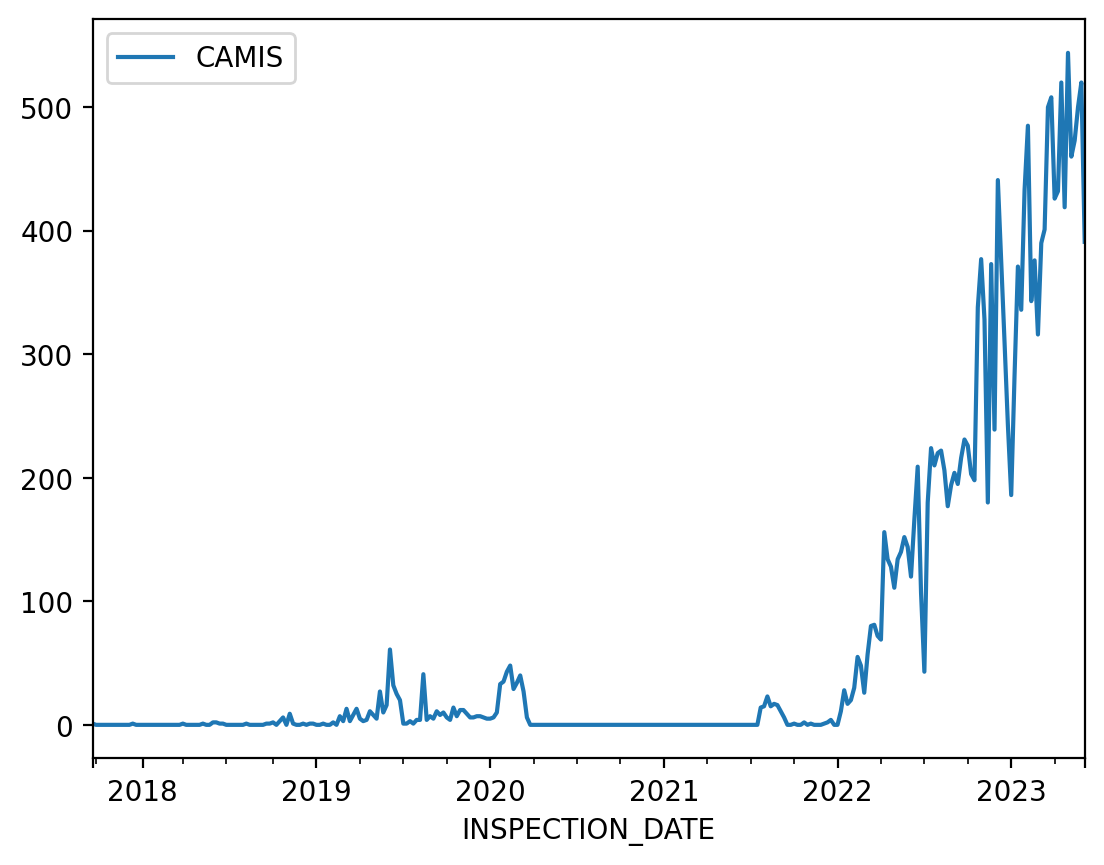

In [134]:
# Distribution of last inspection across all restaurants
inspection_stats['max'].sort_values('INSPECTION_DATE').reset_index().pivot_table(
    index='INSPECTION_DATE',
    aggfunc='count'
).resample('1W').sum().plot()

In [ ]:
# Longevity 
# (inspection_stats['max'] - inspection_stats['min'])['INSPECTION DATE'].sort_values()

<Axes: >

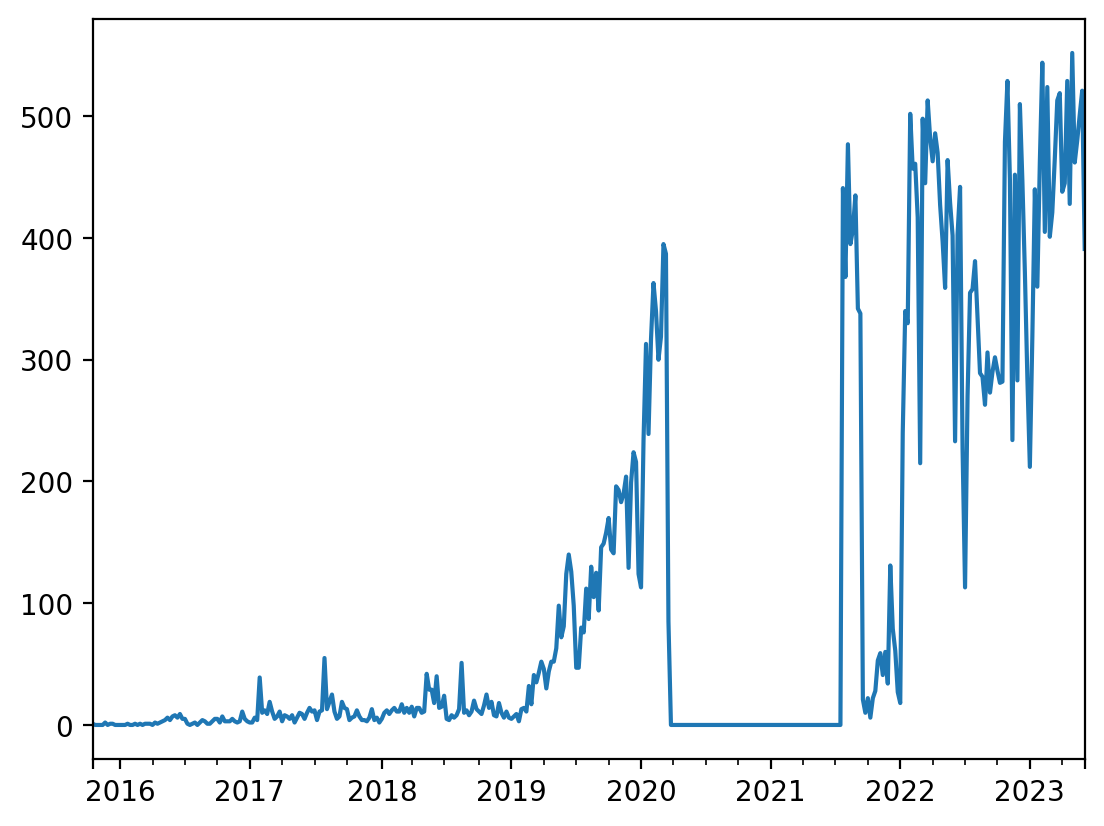

In [135]:
# Distribution of all inspections
inspection['INSPECTION_DATE'].value_counts().sort_index().resample('1W').sum().plot()

In [136]:
len(df)

133595

In [137]:
violations = pd.merge(
    inspection,
    df[ ['CAMIS', 'INSPECTION_DATE', 'VIOLATION_CODE' ] ],
    on= ['CAMIS', 'INSPECTION_DATE'],
    how = 'inner'
)
violations = violations[ ['INSPECTION_ID', 'VIOLATION_CODE'] ].drop_duplicates()
len(violations)

133591

In [138]:
print(f"Violations: {len(violations)}")
print(f"Inspections: {len(inspection)}")
print(f"Restaurants: {len(restaurants)}")
print(f"Violation Codes: {len(violation_codes)}")

Violations: 133591
Inspections: 42836
Restaurants: 19221
Violation Codes: 149


## Storing in MySQL


In [140]:
!sudo pip3 install -U -q PyMySQL sqlalchemy sql_magic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 9.0 MB/s eta 0:00:00


In [145]:
import os
from sqlalchemy import create_engine
from sqlalchemy import text

conn_string = 'mysql+pymysql://{user}:{password}@{host}/?charset=utf8mb4'.format(
    host = 'db.ipeirotis.org', 
    user = 'root',
    password = 'ae6jQniBS5muV27', #os.environ['MYSQL_PASSWORD'],
    encoding = 'utf8mb4')

engine = create_engine(conn_string)
con = engine.connect()

In [147]:
# Query to create a database
db_name = 'doh_restaurants'

sql = f"DROP DATABASE IF EXISTS {db_name}"
with engine.connect() as connection:
  connection.execute(text(sql))

# Create a database
sql = f"CREATE DATABASE IF NOT EXISTS {db_name} DEFAULT CHARACTER SET 'utf8mb4'"
with engine.connect() as connection:
  connection.execute(text(sql))

# And lets switch to the database
sql = f"USE {db_name}"
with engine.connect() as connection:
  connection.execute(text(sql))

In [148]:
create_table_sql = '''
CREATE TABLE restaurants (
    CAMIS                      char(8),
    DBA varchar(90), 
    BUILDING varchar(10), 
    STREET varchar(40), 
    ZIPCODE char(5), 
    BORO ENUM('Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island')  ,
    PHONE char(10), 
    CUISINE_DESCRIPTION    varchar(30),
LATITUDE                float,
LONGITUDE               float,
COMMUNITY_BOARD          char(3),
COUNCIL_DISTRICT         char(2),
CENSUS_TRACT             char(6),
BIN                      char(7),
BBL                      char(10),
NTA                      char(4), 
PRIMARY KEY(CAMIS)   
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
'''
with engine.connect() as connection:
  connection.execute(text(create_table_sql))


create_table_sql = '''
CREATE TABLE inspections (
    INSPECTION_ID               char(8),
    CAMIS                      char(8),
    INSPECTION_DATE    datetime,
    ACTION                   ENUM('Violations found','Establishment closed','No violations'),
    SCORE                     smallint,
    GRADE                    char(1),
    INSPECTION_TYPE          ENUM('Initial Inspection','Re-inspection'),
    FOREIGN KEY(CAMIS) REFERENCES restaurants(CAMIS),
    PRIMARY KEY(INSPECTION_ID) 
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
'''
with engine.connect() as connection:
  connection.execute(text(create_table_sql))

create_table_sql = '''
CREATE TABLE violation_codes (
  VIOLATION_CODE     char(5),
  DESCRIPTION varchar(1000),
  CRITICAL ENUM('Critical', 'Not Applicable', 'Not Critical')
  -- PRIMARY KEY(VIOLATION_CODE)

) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
'''
with engine.connect() as connection:
  connection.execute(text(create_table_sql))


create_table_sql = '''
CREATE TABLE violations (
  INSPECTION_ID         char(8),
  VIOLATION_CODE     char(5),
  FOREIGN KEY(INSPECTION_ID) REFERENCES inspections(INSPECTION_ID)
  -- FOREIGN KEY(VIOLATION_CODE) REFERENCES violation_codes(VIOLATION_CODE)
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
'''
with engine.connect() as connection:
  connection.execute(text(create_table_sql))

In [149]:
violation_codes.reset_index().VIOLATION_CODE.str.len().max()

5

In [150]:
violation_codes.reset_index().to_sql(
        name = 'violation_codes', 
        schema = db_name, 
        con = engine,
        if_exists = 'append',
        index = False, 
        chunksize = 1000)

149

In [151]:
restaurants.to_sql(
        name = 'restaurants', 
        schema = db_name, 
        con = engine,
        if_exists = 'append',
        index = False, 
        chunksize = 1000)

19221

In [152]:
inspection.to_sql(
        name = 'inspections', 
        schema = db_name, 
        con = engine,
        if_exists = 'append',
        index = False, 
        chunksize = 1000)

42836

In [153]:
violations.to_sql(
        name = 'violations', 
        schema = db_name, 
        con = engine,
        if_exists = 'append',
        index = False, 
        chunksize = 1000)

133591

In [155]:
sql = '''
GRANT SELECT ON doh_restaurants.* TO 'student'@'%'
'''
with engine.connect() as connection:
  connection.execute(text(sql))

In [156]:


sql = '''
CREATE VIEW restaurant_inspection_latest AS 
	WITH latest_inspection AS (
		SELECT CAMIS, MAX(INSPECTION_DATE) AS INSPECTION_DATE FROM inspections
		GROUP BY CAMIS
	)
	SELECT R.CAMIS, R.DBA, R.BUILDING, R.STREET, R.ZIPCODE, R.BORO, R.CUISINE_DESCRIPTION, R.LATITUDE, R.LONGITUDE, I.INSPECTION_DATE, I.INSPECTION_ID, I.INSPECTION_TYPE, V.VIOLATION_CODE, I.SCORE, I.GRADE
		FROM restaurants R
			JOIN latest_inspection L ON R.CAMIS = L.CAMIS
			JOIN inspections I ON I.CAMIS = L.CAMIS AND L.INSPECTION_DATE = I.INSPECTION_DATE
			JOIN violations V ON I.INSPECTION_ID = V.INSPECTION_ID
      '''

with engine.connect() as connection:
  connection.execute(text(sql))